In [1]:
####### Trying to implement Micrograd #######
!arch -arm64 brew install graphviz

==> Downloading https://ghcr.io/v2/homebrew/core/graphviz/manifests/9.0.0
######################################################################### 100.0%
==> Fetching dependencies for graphviz: libpng, freetype, fontconfig, jpeg-turbo, brotli, giflib, highway, imath, xz, lz4, zstd, libtiff, little-cms2, openexr, webp, jpeg-xl, libvmaf, aom, libavif, gd, pcre2, glib, jasper, netpbm, gts, xorgproto, libxau, libxdmcp, libxcb, libx11, libxext, libxrender, lzo, pixman, cairo, gdk-pixbuf, fribidi, graphite2, icu4c, harfbuzz, pango, librsvg, m4 and libtool
==> Downloading https://ghcr.io/v2/homebrew/core/libpng/manifests/1.6.42
######################################################################### 100.0%
==> Fetching libpng
==> Downloading https://ghcr.io/v2/homebrew/core/libpng/blobs/sha256:47979a2dc1d
######################################################################### 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/freetype/manifests/2.13.2-1
##############################

In [2]:
import math 

In [3]:
class Value:
    def __init__(self,data,children=(),op='',label=''):
        # initialize data 
        self.data = data 
        self._backward = lambda: None
        self._prev = set(children)
        self._op = op
        self.label = label
        self.grad = 0.0

    def __repr__(self):
        # __repr__ is a way to beautify the output  
        return f'Value = {self.data}'
    def __add__(self,next_operand):
        operation = self.data+next_operand.data
        operation = Value(operation,(self,next_operand),'+')
        
        def _backward():
            self.grad = 1.0*operation.grad
            next_operand.grad = 1.0*operation.grad
        operation._backward = _backward

        return operation

    def __sub__(self,next_operand):
        operation = self.data - next_operand.data
        operation = Value(operation,(self,next_operand),'-')

        def _backward():
            self.grad = 1.0*operation.grad
            next_operand.grad = 1.0*operation.grad
            
        operation._backward = _backward

        return operation

    def __mul__(self,next_operand):
        operation = self.data * next_operand.data
        operation = Value(operation,(self,next_operand),'*')

        def _backward():
            self.grad = operation.grad*next_operand.data
            next_operand = operation.grad*self.data

        operation._backward = _backward
        return operation
    
    def sigmoid(self):
        sig =  (1/(1+math.exp(-self.data)))
        operation = Value(sig,(self,),'sigmoid')

        def _backward():
            self.grad = sig*(1-sig)*operation.grad
        operation._backward = _backward

        return operation

    
    
    # def __truediv__(self,next_operand):
    #     operation = self.data/next_operand.data
    #     return Value(operation,(self,next_operand),'/')


In [4]:
# graphviz code is by andrej karpathyfrom graphviz import Digraph
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [5]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L


Value = -8.0

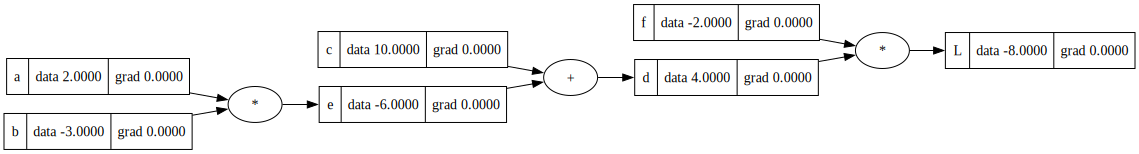

In [6]:
draw_dot(L)

In [14]:
L.label

'L'